# Anomaly Detection

In [3]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.optimize

In [5]:
datafile = os.getcwd() + '/ex8data1.mat'
mat = scipy.io.loadmat(datafile)
X = mat['X']
ycv = mat['yval']
xcv = mat['Xval']

In [6]:
def plotData(myX, newFig=False):
    if newFig:
        plt.figure(figsize=(8,6))
    plt.plot(myX[:,0],myX[:,1],'b+')
    plt.xlabel('Latency[ms]', fontsize=16)
    plt.ylabel('Throughput [mb/s]', fontsize=16)
    plt.grid(True)

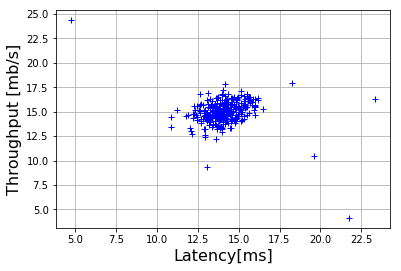

In [7]:
plotData(X)

### Gaussian Distribution

In [8]:
def gaus(myX, mymu, mysig2):
    m = myX.shape[0]
    n = myX.shape[1]
    if np.ndim(mysig2) == 1:
        mysig2 = np.diag(mysig2)
    norm = 1./(np.power((2*np.pi),n/2)*np.sqrt(np.linalg.det(mysig2)))
    myinv = np.linalg.inv(mysig2)
    myexp = np.zeros((m,1))
    for irow in range(m):
        xrow = myX[irow]
        myexp[irow] = np.exp(-0.5*((xrow-mymu).T).dot(myinv).dot(xrow-mymu))
    return norm*myexp

In [16]:
#Parameter estimation for Gaussian
def getGaussianParams(myX, useMultivariate=True):
    m = myX.shape[0]
    mu = np.mean(myX, axis=0)
    if not useMultivariate:
        sigma2 = np.sum(np.square(myX-mu), axis=0)/float(m)
        return mu, sigma2
    else:
        sigma2 = ((myX-mu).T.dot(myX-mu))/float(m)
        return mu, sigma2

In [17]:
mu, sig2 = getGaussianParams(X, useMultivariate=True)

In [20]:
def plotContours(mymu, mysigma2, newFig=False, useMultivariate=True):
    delta = 0.5
    myx = np.arange(0,30,delta)
    myy = np.arange(0,30,delta)
    meshx, meshy = np.meshgrid(myx,myy)
    coord_list = [entry.ravel() for entry in (meshx, meshy)]
    points = np.vstack(coord_list).T
    myz = gaus(points, mymu, mysigma2)
    myz = myz.reshape((myx.shape[0],myy.shape[0]))
    
    if newFig:
        plt.figure(figsize=(6,4))
    cont_levels = [10**exp for exp in range(-20,0,3)]
    mycont = plt.contour(meshx, meshy, myz, levels=cont_levels)
    
    plt.title('Gaussian Contours', fontsize=16)

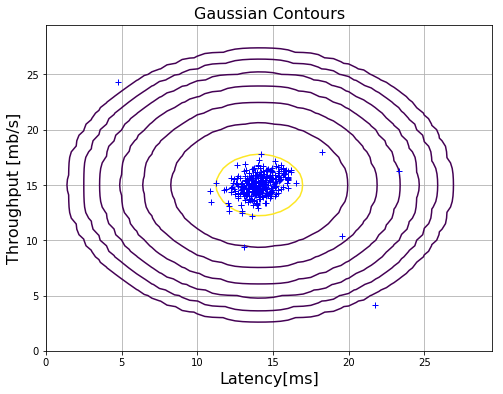

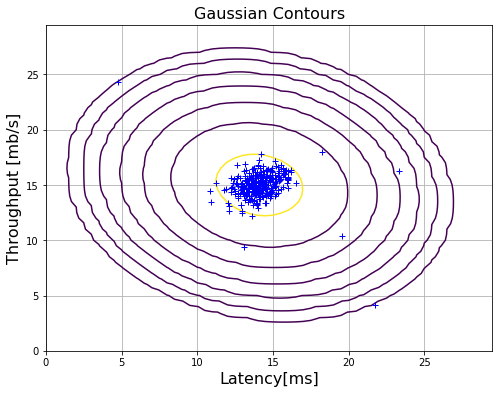

In [24]:
#Non-multivariate Gaussian
plotData(X,newFig=True)
useMV=False
plotContours(*getGaussianParams(X,useMV),newFig=False, useMultivariate=useMV)

#Multivariate Gaussian
plotData(X,newFig=True)
useMV = True
plotContours(*getGaussianParams(X,useMV),newFig=False,useMultivariate=useMV)

In [25]:
#Selecting threshold
def computeF1(predVec, trueVec):
    P,R = 0.,0.
    if float(np.sum(predVec)):
        P = np.sum([int(trueVec[x]) for x in range(predVec.shape[0])
                   if trueVec[x]]) / float(np.sum(trueVec))
    if float(np.sum(trueVec)):
        R = np.sum([int(predVec[x]) for x in range(trueVec.shape[0])
                   if trueVec[x]]) / float(np.sum(trueVec))
    return 2*P*R/(P+R) if (P+R) else 0

In [27]:
def selectThreshold(myycv, mypCVs):
    #Select the best possible epsilon from the CV set
    nsteps = 1000
    epses = np.linspace(np.min(mypCVs), np.max(mypCVs),nsteps)
    #Compute the F1 score and keep best possibl score, this will be used
    bestF1, bestEps = 0,0
    trueVec = (myycv == 1).flatten()
    for eps in epses:
        predVec = mypCVs < eps
        thisF1 = computeF1(predVec, trueVec)
        if thisF1 > bestF1:
            bestF1 = thisF1
            bestEps = eps
    print ('Best F1 is %f, best epsilon is %0.4g'%(bestF1, bestEps))
    return bestF1, bestEps

In [30]:
pCVs = gaus(xcv, mu, sig2)
bestF1, bestEps = selectThreshold(ycv, pCVs)

Best F1 is 1.000000, best epsilon is 0.07786


In [31]:
def plotAnomalies(myX, mybestEps, newFig=False, useMultivariate=True):
    ps = gaus(myX, *getGaussianParams(myX, useMultivariate))
    anoms = np.array([myX[x] for x in range(myX.shape[0]) if ps[x] < mybestEps])
    if newFig:
        plt.figure(figsiz(6,4))
    plt.scatter(anoms[:,0], anoms[:,1], s=80, facecolors='none', edgecolors='r')

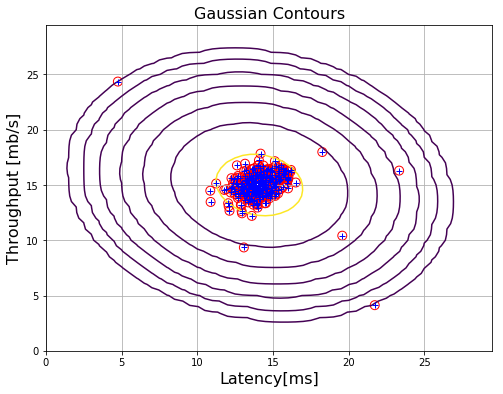

In [32]:
plotData(X, newFig = True)
plotContours(mu, sig2, newFig=False, useMultivariate=True)
plotAnomalies(X, bestEps, newFig=False, useMultivariate=True)

# Recommender Systems

In [33]:
datafile = os.getcwd() + '/ex8_movies.mat'
mat = scipy.io.loadmat(datafile)
Y = mat['Y']
R = mat['R']

nm, nu = Y.shape
#Y is a matrix containing movie ratings (1-5) of 1682 movies for 943 users
#R is a matrix that is R(i,j) = 1 if user j gave a rating to movie i

Average rating for Toy Story: 3.88


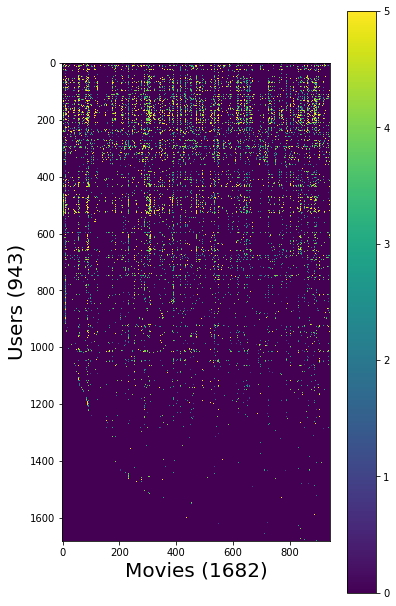

In [40]:
print ('Average rating for Toy Story: %0.2f' % (np.mean([Y[0][x] for x in 
    range(Y.shape[1]) if R[0][x]])))
fig = plt.figure(figsize=(6,6*(1682./943.)))
dummy = plt.imshow(Y)
dummy = plt.colorbar()
dummy = plt.xlabel('Movies (%d)'%nm,fontsize=20)
dummy = plt.ylabel('Users (%d)' %nu, fontsize=20)


Throughout this part of the exercise, you will also be 
working with the matrices, X and Theta
The i-th row of X corresponds to the feature vector x(i) for the i-th movie, 
and the j-th row of Theta corresponds to one parameter vector θ(j), for the j-th user. 
Both x(i) and θ(j) are n-dimensional vectors. For the purposes of this exercise, 
you will use n = 100, and therefore, x(i) ∈ R100 and θ(j) ∈ R100. Correspondingly, 
X is a nm × 100 matrix and Theta is a nu × 100 matrix.

### Collaborative Filtering Learning Algorithm

In [65]:
datafile = os.getcwd() + '/ex8_movieParams.mat'
mat = scipy.io.loadmat(datafile)
X = mat['X']
Theta = mat['Theta']
nu = int(mat['num_users'])
nm = int(mat['num_movies'])
nf = int(mat['num_features'])
#Reduce dataset for faster processing
nu = 4; nm = 5; nf = 3;
X = X[:nm,:nf]
Theta = Theta[:nu,:nf]
Y = Y[:nm, :nu]
R = R[:nm, :nu]

In [66]:
#Flatten matrices into one long array
def flattenParams(myX, myTheta):
    # (nm*nf + nu*nf,1)
    flattened = np.concatenate((myX.flatten(), myTheta.flatten()))
    return flattened
def reshapeParams(flattened_XandTheta, mynm, mynu, mynf):
    assert flattened_XandTheta.shape[0] == int(nm*nf+nu*nf)
    
    reX = flattened_XandTheta[:int(mynm*mynf)].reshape((mynm,mynf))
    reTheta = flattened_XandTheta[int(mynm*mynf):].reshape((mynu,mynf))
    
    return reX, reTheta

In [67]:
def cofiCostFunc(myparams, myY, myR, mynu, mynm, mynf, mylambda = 0.):
    myX, myTheta = reshapeParams(myparams, mynm, mynu, mynf)
    #X = (nm x nf), Theta = (nu x nf), Y = (nm x nu), R = (nm x nu)
    term1 = myX.dot(myTheta.T)
    term1 = np.multiply(term1, myR)
    cost = 0.5 * np.sum(np.square(term1-myY))
    
    #Regularization
    cost += (mylambda/2.) * np.sum(np.square(myTheta))
    cost += (mylambda/2.) * np.sum(np.square(myX))
    
    return cost

In [68]:
print ('Cost with nu=4, nm = 5, nm = 3 is %0.2f' 
      %cofiCostFunc(flattenParams(X,Theta), Y, R, nu, nm ,nf))

print ('Cost with nu=4, nm=5, nf=3, lambda =1.5 %0.2f'%cofiCostFunc(flattenParams(X,Theta), Y, R, nu, nm, nf, mylambda=1.5))

Cost with nu=4, nm = 5, nm = 3 is 22.22
Cost with nu=4, nm=5, nf=3, lambda =1.5 31.34


In [74]:
def cofiGrad(myparams, myY, myR, mynu, mynm, mynf, mylambda=0.):
    # First the X gradient term 
    # First dot theta and X together such that you get a matrix the same shape as Y
    # Then multiply this term by myR to remove any components from movies that
    # weren't rated by that user
    # Now subtract the y matrix (which already has 0 for nonrated movies)
    # Lastly dot this with Theta such that the resulting matrix has the
    # same shape as the X matrix
    myX, myTheta = reshapeParams(myparams,mynm, mynu, mynf)
    term1 = myX.dot(myTheta.T)
    term1 = np.multiply(term1, myR)
    term1 -=myY
    Xgrad = term1.dot(myTheta)
    Thetagrad = term1.T.dot(myX)
    Xgrad += mylambda * myX
    Thetagrad += mylambda * myTheta
    return flattenParams(Xgrad, Thetagrad)

In [75]:
def checkGradient(myparams, myY, myR, mynu, mynm, mynf, mylambda=0.):
    myeps = 0.001
    nparams = len(myparams)
    epsvec = np.zeros(nparams)
    mygrads = cofiGrad(myparams, myY, myR, mynu, mynm, mynf, mylambda)
    
    for i in range(10):
        idx = np.random.randint(0,nparams)
        epsvec[idx] = myeps
        loss1 = cofiCostFunc(myparams-epsvec, myY, myR, mynu, mynm, mynf, mylambda)
        loss2 = cofiCostFunc(myparams+epsvec, myY, myR, mynu, mynm, mynf, mylambda)
        mygrad = (loss2 - loss1) / (2*myeps)
        epsvec[idx] = 0
        print ('%0.15f \t %0.15f \t %0.15f' %(mygrad, mygrads[idx], mygrad - mygrads[idx]))

In [76]:
print ('Checking gradient with lambda = 0...')
checkGradient(flattenParams(X,Theta), Y, R, nu, nm, nf)
print ('Checking gradient with lambda = 1.5...')
checkGradient(flattenParams(X, Theta), Y, R, nu, nm, nf, mylambda=1.5)

Checking gradient with lambda = 0...
3.352650312848482 	 3.352650312849549 	 -0.000000000001067
-0.523398454966184 	 -0.523398454966595 	 0.000000000000411
-1.899790261385093 	 -1.899790261386604 	 0.000000000001511
0.000000000000000 	 0.000000000000000 	 0.000000000000000
0.000000000000000 	 0.000000000000000 	 0.000000000000000
-0.523398454966184 	 -0.523398454966595 	 0.000000000000411
2.263336983922670 	 2.263336983921972 	 0.000000000000699
0.000000000000000 	 0.000000000000000 	 0.000000000000000
0.000000000000000 	 0.000000000000000 	 0.000000000000000
-3.474107886729527 	 -3.474107886729185 	 -0.000000000000342
Checking gradient with lambda = 1.5...
1.063009327570086 	 1.063009327570006 	 0.000000000000079
6.975355139747563 	 6.975355139747124 	 0.000000000000440
-0.892473343597544 	 -0.892473343597432 	 -0.000000000000112
1.270066658644708 	 1.270066658643917 	 0.000000000000791
0.129856157162322 	 0.129856157163688 	 -0.000000000001366
-0.892473343597544 	 -0.892473343597432 

### Movie Recommendations

In [77]:
movies = []
with open('movie_ids.txt') as f:
    for line in f:
        movies.append(' '.join(line.strip('/n').split(' ')[1:]))
        
my_ratings = np.zeros((1682,1))
my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [78]:
datafile = os.getcwd() + '/ex8_movies.mat'
mat = scipy.io.loadmat(datafile)
Y = mat['Y']
R = mat['R']
nf = 10

In [79]:
myR_row = my_ratings > 0
Y = np.hstack((Y, my_ratings))
R = np.hstack((R, myR_row))
nm, nu = Y.shape

In [80]:
def normalizeRatings(myY, myR):
    #Preprocess data by subtracting mean rating for every movie (every row)
    #This is important because without this, a user who hasn't rated any movies
    #will have a predicted score of 0 for every movie, when in reality
    #they should have a predicted score of [average score of that movie].  
    Ymean = np.sum(myY, axis=1)/np.sum(myR, axis=1)
    Ymean = Ymean.reshape((Ymean.shape[0],1))
    return myY-Ymean, Ymean

In [81]:
Ynorm, Ymean = normalizeRatings(Y,R)

In [83]:
X = np.random.rand(nm, nf)
Theta = np.random.rand(nu,nf)
myflat = flattenParams(X, Theta)

mylambda = 10.

result = scipy.optimize.fmin_cg(cofiCostFunc, x0=myflat, fprime=cofiGrad,
args=(Y, R, nu, nm, nf, mylambda),maxiter=50, disp=True, full_output=True)


         Current function value: 72939.679731
         Iterations: 50
         Function evaluations: 72
         Gradient evaluations: 72


In [84]:
resX, resTheta = reshapeParams(result[0], nm, nu, nf)
prediction_matrix = resX.dot(resTheta.T)

In [85]:
my_predictions = prediction_matrix[:,-1] + Ymean.flatten()

In [87]:
pred_idxs_sorted = np.argsort(my_predictions)
pred_idxs_sorted[:] = pred_idxs_sorted[::-1]
print('Top recommendations for you:')
for i in range(10):
    print ('Predicted rating %0.1f for movie %s' %(my_predictions[pred_idxs_sorted[i]]
        ,movies[pred_idxs_sorted[i]]))
print ('Original ratings:')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print ('Rated %d for movie %s' %(my_ratings[i], movies[i]))

Top recommendations for you:
Predicted rating 8.3 for movie Titanic (1997)

Predicted rating 8.3 for movie Shawshank Redemption, The (1994)

Predicted rating 8.3 for movie Schindler's List (1993)

Predicted rating 8.2 for movie Star Wars (1977)

Predicted rating 8.1 for movie Good Will Hunting (1997)

Predicted rating 8.1 for movie Raiders of the Lost Ark (1981)

Predicted rating 8.0 for movie Wrong Trousers, The (1993)

Predicted rating 8.0 for movie Close Shave, A (1995)

Predicted rating 8.0 for movie Casablanca (1942)

Predicted rating 8.0 for movie Usual Suspects, The (1995)

Original ratings:
Rated 4 for movie Toy Story (1995)

Rated 3 for movie Twelve Monkeys (1995)

Rated 5 for movie Usual Suspects, The (1995)

Rated 4 for movie Outbreak (1995)

Rated 5 for movie Shawshank Redemption, The (1994)

Rated 3 for movie While You Were Sleeping (1995)

Rated 5 for movie Forrest Gump (1994)

Rated 2 for movie Silence of the Lambs, The (1991)

Rated 4 for movie Alien (1979)

Rated 5 for